### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 7


### Дисциплина: Методы машинного обучения

##### Студент:  Миронов Дмитрий Андреевич
##### Группа:   НПИбд-02-21

## Москва 2024
***

### Вариант №15

1. Набор данных: svhn_cropped

2. Диапазон классов: 0, 1, 2, 3, 4

3. Архитектура автокодировщика: MLP

4. Показатель качества: cреднее квадратичное логарифмическое отклонение (MSLE) для ошибки реконструкции

5. Показатель качества бинарной классификации:

F1-мера, равная 2*TP/(2*TP+FP+FN)

1.	Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки. Оставьте в обучающей и тестовой выборках диапазон классов, указанных в индивидуальном задании. Если изображения цветные (с тремя каналами), то перекодируйте их в одноцветные (оттенки серого).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import random
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

In [4]:
ds = tfds.load("svhn_cropped", split=['train', 'test'])
df_train = tfds.as_dataframe(ds[0])
df_test = tfds.as_dataframe(ds[1])

df_train.shape, df_test.shape
df_train.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteBHHY5C/svhn_cropped-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteBHHY5C/svhn_cropped-test.tfrecord*...:   0%| …

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteBHHY5C/svhn_cropped-extra.tfrecord*...:   0%|…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.


,image,label
0,"[[[126, 138, 136], [128, 138, 137], [129, 139,...",4
1,"[[[78, 86, 105], [80, 87, 107], [78, 85, 106],...",8
2,"[[[66, 65, 65], [72, 73, 72], [76, 77, 77], [8...",7
3,"[[[85, 83, 96], [68, 66, 80], [58, 56, 75], [5...",2
4,"[[[186, 191, 185], [186, 192, 185], [186, 193,...",6


In [5]:
sorted(df_train['label'].unique()), sorted(df_test['label'].unique())

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [6]:
df_train = df_train[df_train['label'].isin([0, 1, 2, 3, 4])]
df_test = df_test[df_test['label'].isin([0, 1, 2, 3, 4])]
df_train.shape, df_test.shape

((45349, 2), (16397, 2))

In [7]:
sorted(df_train['label'].unique()), sorted(df_test['label'].unique())

([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])

In [8]:
def plot_random_sample(images, n=10, num_row=2, num_col=5):
    imgs = random.sample(list(images), n)
    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    for i in range(num_row * num_col):
        img = rgb2gray(imgs[i])  # Преобразуем изображение в оттенки серого
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img, cmap='gray')  # Устанавливаем colormap в 'gray'
        ax.axis('off')  # Скрываем оси для более чистого отображения

    plt.tight_layout()
    plt.show()

In [9]:
df_train_images = np.array([image/ 255.0 for image in df_train['image']])

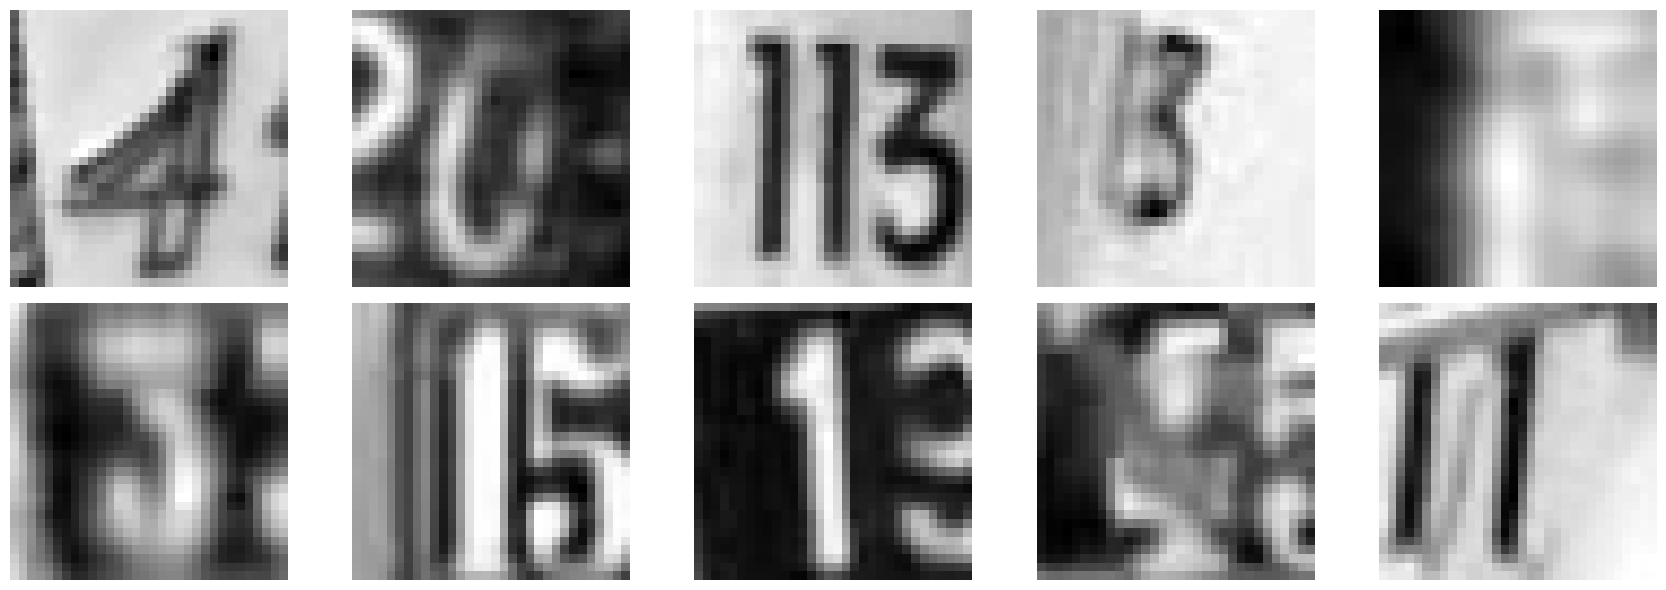

In [10]:
plot_random_sample(df_train_images)

2.	Постройте для набора данных график логарифмического правдоподобия профиля в зависимости от числа главных компонент и определите размерность латентного пространства.

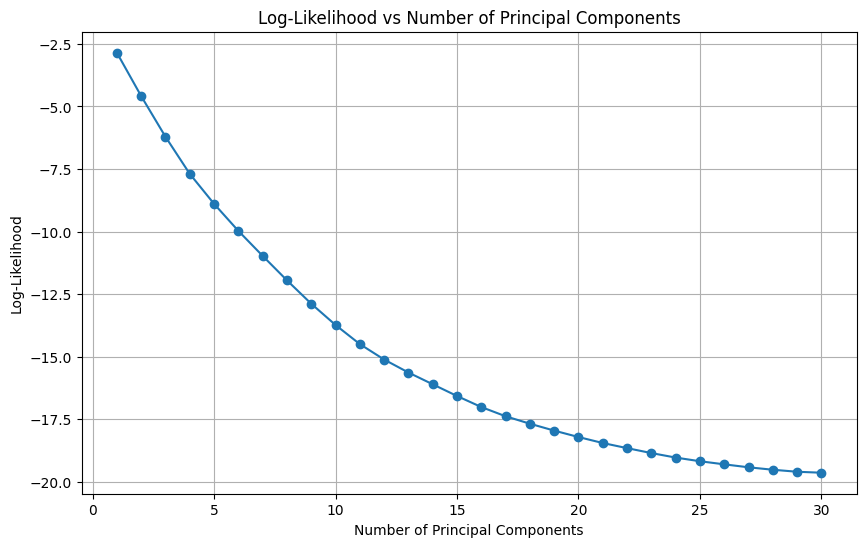

In [11]:
# Уменьшение размера изображений для ускорения выполнения
def resize_images(images, new_size=(32, 32)):
    return np.array([resize(image, new_size, anti_aliasing=True) for image in images])

# Преобразование изображений в одномерные массивы
df_train_resized = resize_images(df_train_images, new_size=(16, 16))
df_train_flattened = df_train_resized.reshape(len(df_train_resized), -1)

# Функция для вычисления логарифмического правдоподобия профиля
def compute_log_likelihood(data, n_components):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)
    gmm = GaussianMixture(n_components=1, max_iter=100, n_init=1)
    gmm.fit(reduced_data)
    log_likelihood = gmm.score(reduced_data)
    return log_likelihood

# Массив для хранения значений логарифмического правдоподобия профиля
n_components_range = range(1, 31)  # Уменьшенный диапазон для ускорения выполнения
log_likelihoods = []

# Вычисление логарифмического правдоподобия профиля для различных чисел главных компонент
for n in n_components_range:
    log_likelihood = compute_log_likelihood(df_train_flattened, n)
    log_likelihoods.append(log_likelihood)

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, log_likelihoods, marker='o')
plt.title('Log-Likelihood vs Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.show()


3.	Создайте и обучите на обучающей выборке автокодировщик архитектуры, указанной в индивидуальном задании, с размерностью скрытого представления, равной размерности латентного пространства, определенной в п.2. Подберите такие параметры, как функции активации, оптимизатор, начальная скорость обучения, размер мини-пакета и др. самостоятельно, обеспечивая обучение нейронных сетей. Визуализируйте несколько исходных и восстановленных автокодировщиком изображений.  

Epoch 1/50
142/142 [==============================] - 4s 10ms/step - loss: 0.6579 - val_loss: 0.6329
Epoch 2/50
142/142 [==============================] - 1s 8ms/step - loss: 0.6294 - val_loss: 0.6279
Epoch 3/50
142/142 [==============================] - 1s 7ms/step - loss: 0.6276 - val_loss: 0.6243
Epoch 4/50
142/142 [==============================] - 1s 8ms/step - loss: 0.6249 - val_loss: 0.6243
Epoch 5/50
142/142 [==============================] - 1s 9ms/step - loss: 0.6247 - val_loss: 0.6236
Epoch 6/50
142/142 [==============================] - 1s 10ms/step - loss: 0.6233 - val_loss: 0.6211
Epoch 7/50
142/142 [==============================] - 1s 9ms/step - loss: 0.6216 - val_loss: 0.6209
Epoch 8/50
142/142 [==============================] - 1s 7ms/step - loss: 0.6214 - val_loss: 0.6206
Epoch 9/50
142/142 [==============================] - 1s 8ms/step - loss: 0.6211 - val_loss: 0.6205
Epoch 10/50
142/142 [==============================] - 1s 6ms/step - loss: 0.6202 - val_loss: 0.61

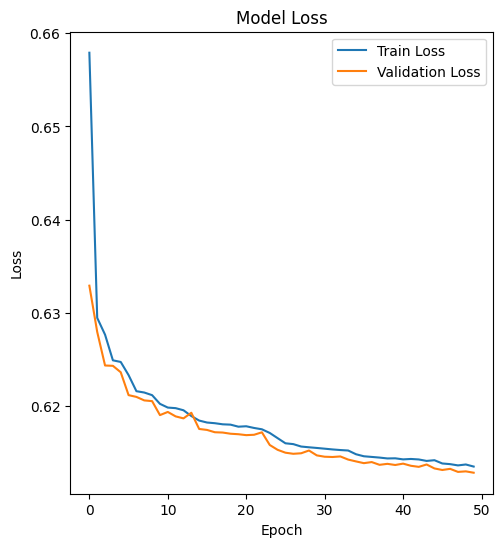

1/1 [==============================] - 0s 79ms/step


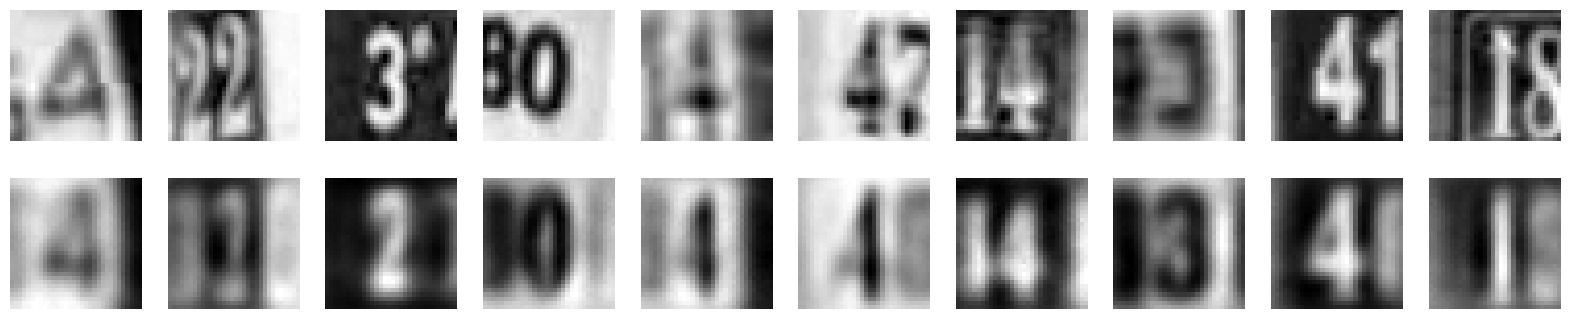

In [38]:
# Определение размера латентного пространства
latent_dim = 20  # Предположим, что оптимальное число главных компонент равно 20

# Подготовка данных
df_train_images_gray = np.array([rgb2gray(image) for image in df_train['image']])
df_train_images_resized = np.array([resize(image, (32, 32)) for image in df_train_images_gray])
df_train_images_resized = df_train_images_resized.reshape(len(df_train_images_resized), -1)  # Преобразуем в одномерные массивы

# Функция для построения автокодировщика MLP
def build_autoencoder(input_shape, latent_dim):
    # Кодировщик
    input_img = Input(shape=(input_shape,))
    x = Dense(512, activation='relu')(input_img)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    encoded = Dense(latent_dim, activation='relu')(x)

    # Декодировщик
    x = Dense(128, activation='relu')(encoded)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    decoded = Dense(input_shape, activation='sigmoid')(x)

    # Модель автокодировщика
    autoencoder = Model(input_img, decoded)
    return autoencoder

# Построение автокодировщика
input_shape = 32 * 32  # Размер одномерного входного массива
autoencoder = build_autoencoder(input_shape, latent_dim)

# Компиляция модели с добавлением метрики точности
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Обучение модели
history = autoencoder.fit(df_train_images_resized, df_train_images_resized, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)

# Визуализация потерь
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Визуализация результатов
def plot_comparison(original_images, decoded_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Исходные изображения
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i].reshape(32, 32), cmap='gray')
        ax.axis('off')

        # Восстановленные изображения
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_images[i].reshape(32, 32), cmap='gray')
        ax.axis('off')
    plt.show()

# Генерация восстановленных изображений
decoded_imgs = autoencoder.predict(df_train_images_resized[:10])

# Визуализация исходных и восстановленных изображений
plot_comparison(df_train_images_resized, decoded_imgs, n=10)

4.	Оцените качество модели автокодировщика на тестовой выборке по показателю, указанному в индивидуальном задании.

In [39]:
from sklearn.metrics import mean_squared_log_error

# Подготовка тестовых данных
df_test_images_gray = np.array([rgb2gray(image) for image in df_test['image']])
df_test_images_resized = np.array([resize(image, (32, 32)) for image in df_test_images_gray])
df_test_images_resized = df_test_images_resized.reshape(len(df_test_images_resized), -1)  # Преобразуем в одномерные массивы

# Проведение предсказаний на тестовых данных
decoded_test_imgs = autoencoder.predict(df_test_images_resized)

# Вычисление MSLE для ошибки реконструкции
msle = mean_squared_log_error(df_test_images_resized, decoded_test_imgs)

# Вывод результата
print(f'Mean Squared Logarithmic Error (MSLE) on test data: {msle}')


513/513 [==============================] - 2s 3ms/step
Mean Squared Logarithmic Error (MSLE) on test data: 0.0026566170791898235


Значение MSLE = 0.0026566170791898235, а это значит что автокодировщик вполне хорошо справляется со своей работой,так как чем ближе значение к 0, тем лучше

5.	Оставьте в наборах изображения первых двух классов диапазона, указанного в индивидуальном задании первыми. Визуализируйте набор данных на плоскости, соответствующей двум первым латентным признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.

214/214 [==============================] - 0s 2ms/step


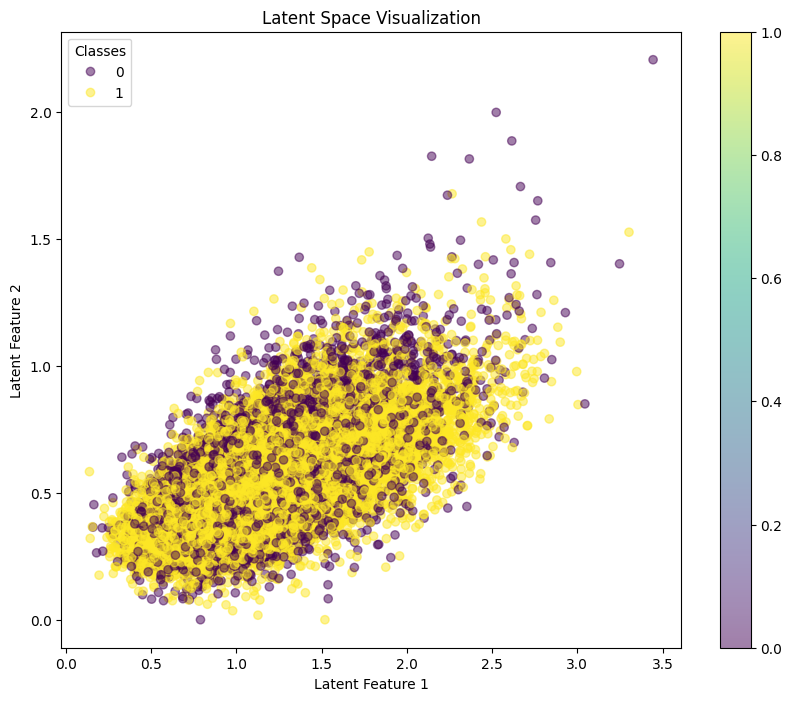

In [33]:
# Фильтрация данных по классам
classes_to_keep = [0, 1]  # Оставляем только изображения классов 0 и 1
df_train_filtered = df_train[df_train['label'].isin(classes_to_keep)]
df_test_filtered = df_test[df_test['label'].isin(classes_to_keep)]


df_test_images_filtered_gray = np.array([rgb2gray(image) for image in df_test_filtered['image']])
df_test_images_filtered_resized = np.array([resize(image, (32, 32)) for image in df_test_images_filtered_gray])
df_test_images_filtered_resized = df_test_images_filtered_resized.reshape(len(df_test_images_filtered_resized), -1)


# Извлечение латентных признаков
encoded_train_imgs = encoder.predict(df_train_images_filtered_resized)
encoded_test_imgs = encoder.predict(df_test_images_filtered_resized)

# Визуализация данных на плоскости с использованием первых двух латентных признаков
def plot_latent_space(encoded_imgs, labels):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('Latent Space Visualization')
    plt.xlabel('Latent Feature 1')
    plt.ylabel('Latent Feature 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=classes_to_keep, title="Classes")
    plt.show()

# Визуализация латентных признаков обучающего набора данных
plot_latent_space(encoded_train_imgs, df_train_filtered['label'])


6.	Выполните бинарную классификацию изображений по латентным (скрытым) признакам и всем признакам при помощи классификатора метода ближайших соседей (kNN). Оцените бинарный классификатор, указанный в индивидуальном задании, для двух построенных классификаторов.

In [34]:
# Фильтрация данных по классам
classes_to_keep = [0, 1]  # Оставляем только изображения классов 0 и 1
df_train_filtered = df_train[df_train['label'].isin(classes_to_keep)]
df_test_filtered = df_test[df_test['label'].isin(classes_to_keep)]

# Подготовка фильтрованных данных
df_train_images_filtered_gray = np.array([rgb2gray(image) for image in df_train_filtered['image']])
df_train_images_filtered_resized = np.array([resize(image, (32, 32)) for image in df_train_images_filtered_gray])
df_train_images_filtered_resized = df_train_images_filtered_resized.reshape(len(df_train_images_filtered_resized), -1)

df_test_images_filtered_gray = np.array([rgb2gray(image) for image in df_test_filtered['image']])
df_test_images_filtered_resized = np.array([resize(image, (32, 32)) for image in df_test_images_filtered_gray])
df_test_images_filtered_resized = df_test_images_filtered_resized.reshape(len(df_test_images_filtered_resized), -1)

# Извлечение латентных признаков
encoded_train_imgs = encoder.predict(df_train_images_filtered_resized)
encoded_test_imgs = encoder.predict(df_test_images_filtered_resized)

# Обучение kNN классификатора на латентных признаках
knn_latent = KNeighborsClassifier(n_neighbors=5)
knn_latent.fit(encoded_train_imgs, df_train_filtered['label'])
pred_latent = knn_latent.predict(encoded_test_imgs)

# Обучение kNN классификатора на всех признаках
knn_all_features = KNeighborsClassifier(n_neighbors=5)
knn_all_features.fit(df_train_images_filtered_resized, df_train_filtered['label'])
pred_all_features = knn_all_features.predict(df_test_images_filtered_resized)

# Оценка классификаторов с использованием F1-меры
f1_latent = f1_score(df_test_filtered['label'], pred_latent)
f1_all_features = f1_score(df_test_filtered['label'], pred_all_features)

# Вывод результатов
print(f'F1-score for kNN on latent features: {f1_latent}')
print(f'F1-score for kNN on all features: {f1_all_features}')

214/214 [==============================] - 0s 2ms/step
F1-score for kNN on latent features: 0.9407984420642649
F1-score for kNN on all features: 0.9476610429447854


7.	Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) (Указание: используйте метод predict_proba() класса KNeighborsClassifier).

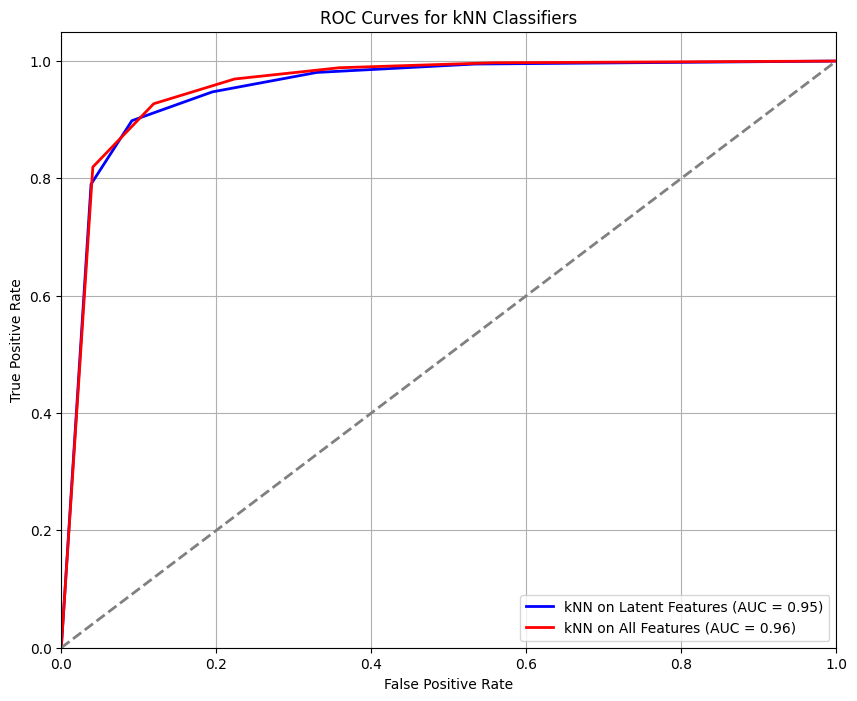

In [35]:
# Получение вероятностей предсказаний для kNN на латентных признаках
probs_latent = knn_latent.predict_proba(encoded_test_imgs)
fpr_latent, tpr_latent, _ = roc_curve(df_test_filtered['label'], probs_latent[:, 1])
roc_auc_latent = auc(fpr_latent, tpr_latent)

# Получение вероятностей предсказаний для kNN на всех признаках
probs_all_features = knn_all_features.predict_proba(df_test_images_filtered_resized)
fpr_all_features, tpr_all_features, _ = roc_curve(df_test_filtered['label'], probs_all_features[:, 1])
roc_auc_all_features = auc(fpr_all_features, tpr_all_features)

# Визуализация ROC-кривых
plt.figure(figsize=(10, 8))
plt.plot(fpr_latent, tpr_latent, color='blue', lw=2, label=f'kNN on Latent Features (AUC = {roc_auc_latent:.2f})')
plt.plot(fpr_all_features, tpr_all_features, color='red', lw=2, label=f'kNN on All Features (AUC = {roc_auc_all_features:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for kNN Classifiers')
plt.legend(loc='lower right')
plt.grid()
plt.show()

8.	Визуализируйте границы принятия решений классификатора kNN для латентных признаков на плоскости, соответствующей двум первым латентным признакам (для прочих латентных признаков задайте средние/медианные значения).  

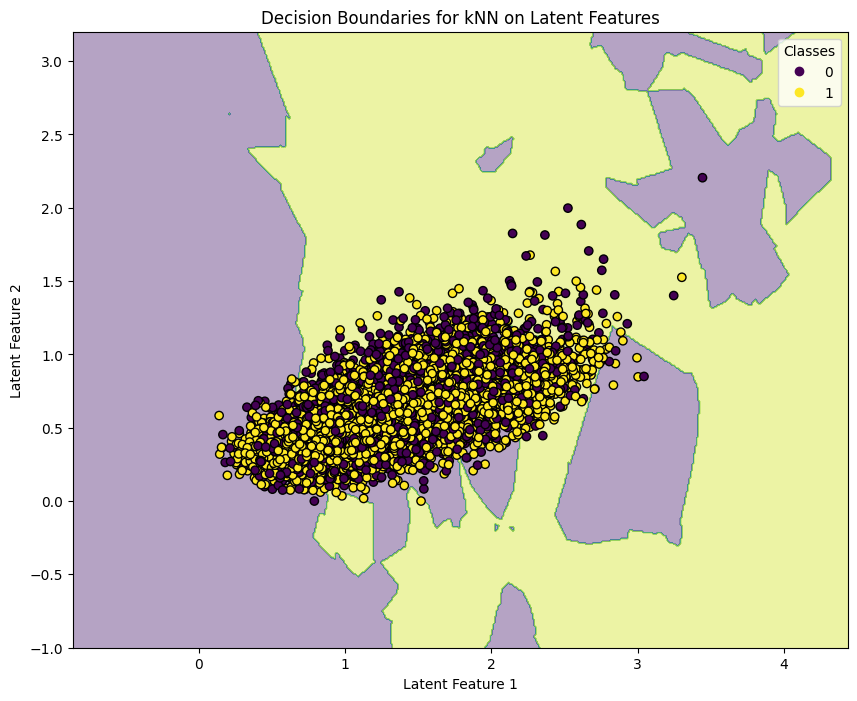

In [36]:
# Определяем диапазон значений для первых двух латентных признаков
x_min, x_max = encoded_train_imgs[:, 0].min() - 1, encoded_train_imgs[:, 0].max() + 1
y_min, y_max = encoded_train_imgs[:, 1].min() - 1, encoded_train_imgs[:, 1].max() + 1

# Создаем сетку точек с шагом 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Для остальных латентных признаков задаем средние значения
encoded_train_mean = encoded_train_imgs.mean(axis=0)
grid_points = np.c_[xx.ravel(), yy.ravel(), np.tile(encoded_train_mean[2:], (xx.ravel().shape[0], 1))]

# Предсказания классов на сетке точек
Z = knn_latent.predict(grid_points)
Z = Z.reshape(xx.shape)

# Визуализация границ принятия решений
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis)

# Отображение обучающих данных
scatter = plt.scatter(encoded_train_imgs[:, 0], encoded_train_imgs[:, 1], c=df_train_filtered['label'], edgecolor='k', cmap=plt.cm.viridis)

# Настройка графика
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.title('Decision Boundaries for kNN on Latent Features')
plt.legend(handles=scatter.legend_elements()[0], labels=classes_to_keep, title="Classes")
plt.show()


9.	Определите на первоначальной тестовой выборке изображение, имеющее наибольшую ошибку реконструкции. Выведите для этого изображения первоначальное и реконструированное изображения.  

513/513 [==============================] - 1s 2ms/step


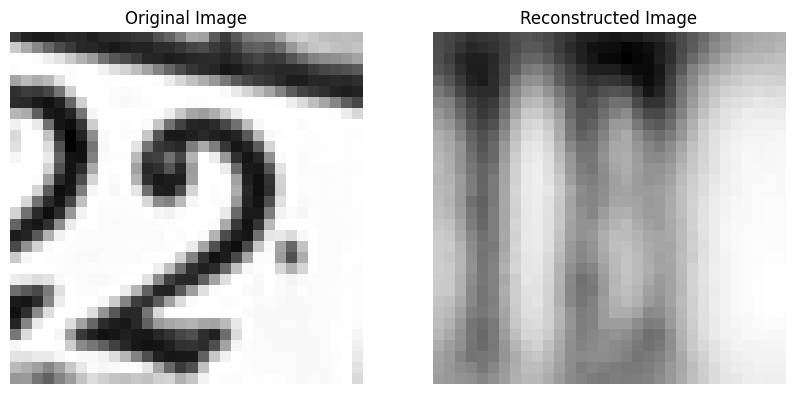

In [31]:
# Пропуск тестовых изображений через автокодировщик
reconstructed_test_imgs = autoencoder.predict(df_test_images_resized)

# Вычисление ошибки реконструкции для каждого изображения (MSE)
reconstruction_errors = np.mean((df_test_images_resized - reconstructed_test_imgs) ** 2, axis=1)

# Нахождение индекса изображения с наибольшей ошибкой реконструкции
max_error_index = np.argmax(reconstruction_errors)

# Первоначальное и реконструированное изображение с наибольшей ошибкой
original_image = df_test_images_resized[max_error_index].reshape(32, 32)
reconstructed_image = reconstructed_test_imgs[max_error_index].reshape(32, 32)

# Визуализация изображений
plt.figure(figsize=(10, 5))

# Первоначальное изображение
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

# Реконструированное изображение
plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()
